**Data Set**

Data set from article single cell RNA sequencing reveals cellular heterogeneity of DLE and SLE from [GSE179633](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE179633), 


In [1]:
import scanpy as sc 
import numpy as np
import pandas as pd  
import GEOparse as geo
from pathlib import Path

In [3]:
data_dir = Path("/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW")
for sample_dir in data_dir.iterdir():
    print(sample_dir)

/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/SLE_5.D
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/HC1zhenpi
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/SLE_1.D
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/SLE_2.D
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/HC1119D
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/HC11118D
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/HC1118E
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/HC2zhenpi1117
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/SLE_3.D
/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW/SLE_4.D


In [4]:
from pathlib import Path
import scanpy as sc

# Directory containing matrix files for each sample
data_dir = Path("/Users/derekmartinez/Desktop/ECBM4060/GSE179633_RAW")

# Read and concatenate all samples
adata_list = []
for sample_dir in data_dir.iterdir():
    if sample_dir.is_dir():
        try:
            adata = sc.read_10x_mtx(sample_dir, var_names="gene_symbols")
            adata.obs["sample"] = sample_dir.name
            if sample_dir.name[:2] == 'SL':
                adata.obs['group'] = 'SLE'
            else:
                adata.obs['group'] = 'Healthy'
            adata_list.append(adata)
        except EOFError as e:
            print(f"Error: Corrupted file in {sample_dir}. Skipping this sample.")
            print(e)
        except Exception as e:
            print(f"Error: {e} occurred for sample {sample_dir}. Skipping this sample.")


In [5]:
len(adata_list)

10

In [6]:
adata_combined = adata_list[0].concatenate(*adata_list[1:], batch_key="sample")

/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94201/1545357242.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_list[0].concatenate(*adata_list[1:], batch_key="sample")


In [9]:
# for adata.var only keep feature_types and gene_ids-0 column
adata_combined.var = adata_combined.var.loc[:, ["gene_ids-0", "feature_types"]]
adata_combined.var

gene_ids-0    feature_types
MIR1302-2HG  ENSG00000243485  Gene Expression
FAM138A      ENSG00000237613  Gene Expression
OR4F5        ENSG00000186092  Gene Expression
AL627309.1   ENSG00000238009  Gene Expression
AL627309.3   ENSG00000239945  Gene Expression
...                      ...              ...
AC023491.2   ENSG00000278633  Gene Expression
AC233755.2   ENSG00000277856  Gene Expression
AC233755.1   ENSG00000275063  Gene Expression
AC240274.1   ENSG00000271254  Gene Expression
AC213203.1   ENSG00000277475  Gene Expression

[31915 rows x 2 columns]

In [10]:
adata_combined.obs 

sample group
AAACCCAAGATAGGGA-1-0      0   SLE
AAACCCAAGATTAGCA-1-0      0   SLE
AAACCCAAGCTCTGTA-1-0      0   SLE
AAACCCACAACGATCT-1-0      0   SLE
AAACCCACAAGGAGTC-1-0      0   SLE
...                     ...   ...
TTTGTTGCAATTCGTG-1-9      9   SLE
TTTGTTGCAGAACGCA-1-9      9   SLE
TTTGTTGCATAATGCC-1-9      9   SLE
TTTGTTGGTGAGCCAA-1-9      9   SLE
TTTGTTGGTTAAGGGC-1-9      9   SLE

[125696 rows x 2 columns]

In [11]:
adata_combined

AnnData object with n_obs × n_vars = 125696 × 31915
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'

In [14]:
markers = ['FOXP3', 'CXCR5', 'CXCR3', 'CXCR6', 'CCR7', 'MKI67', 'ITGAE', 'PTPRC', 'IL2RA', 'NCAM1', 'CD69', 'CD4', 'CD8A', 'CD3E', 'CD28', 'PDCD1', 'RORC', 'PTGDR2', 'B3GAT1']

In [12]:
#filter by CD3E or CD3D 
adata_t = adata_combined[(adata_combined[:,'CD3D'].X > 0)]

In [13]:
adata_t

View of AnnData object with n_obs × n_vars = 15631 × 31915
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'

In [19]:
adata_cd4 = adata_t[(adata_t[:,'CD4'].X > 0)]
adata_cd8 = adata_t[(adata_t[:,'CD8A'].X >0)]

In [20]:
adata_cd8

View of AnnData object with n_obs × n_vars = 2979 × 31915
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'

In [17]:
adata_cd4

View of AnnData object with n_obs × n_vars = 1912 × 31915
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'

In [60]:
sc.pp.normalize_total(adata_t, inplace=True)

normalizing counts per cell
    finished (0:00:00)


In [61]:
sc.pp.log1p(adata_t)

In [62]:
mean_expr = pd.Series(adata_t.X.mean(axis=0).A1 if hasattr(adata_t.X.mean(axis=0), 'A1') else adata_t.X.mean(axis=0).ravel())
mean_expr.index = adata_t.var.index
mean_expr.describe()

count    31915.000000
mean         0.040068
std          0.164752
min          0.000000
25%          0.000015
50%          0.000872
75%          0.020528
max          5.243957
dtype: float64

In [63]:
adata_t = adata_t[:, mean_expr[mean_expr >= 0.000872].index]

In [64]:
adata_t

View of AnnData object with n_obs × n_vars = 15631 × 15956
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'
    uns: 'log1p'

In [65]:
sc.tl.pca(adata_t)

computing PCA
    with n_comps=50


/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


    finished (0:00:36)


In [66]:
sc.pp.neighbors(adata_t, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)


In [67]:
sc.settings.verbosity = 3
sc.tl.umap(adata_t, random_state=0,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)


In [68]:
sc.tl.leiden(adata_t)

running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


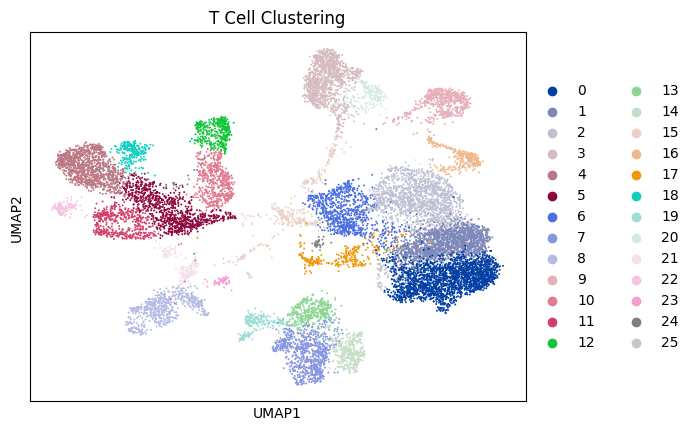

In [69]:
sc.pl.umap(adata_t, color= 'leiden', cmap='turbo', title = 'T Cell Clustering')

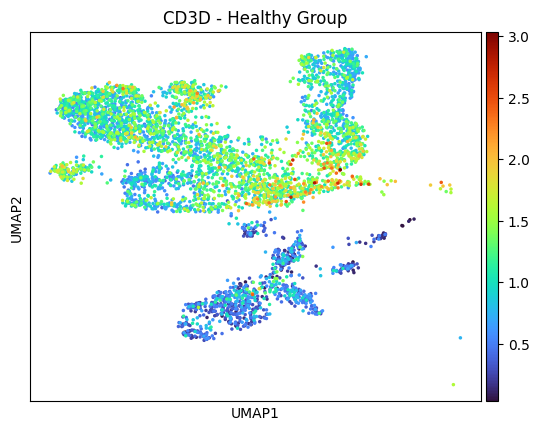

In [70]:
for group in ['Healthy', "SLE"]:
    adata_group = adata_t[adata_t.obs['group'] == group]
    
    # Plot UMAP for each group
    # sc.pl.umap(adata_group, color=['celltype'], title=f'UMAP - {group} Group', cmap='turbo')
    sc.pl.umap(
    adata_group,
    color= 'CD3D',
    title=f'CD3D - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

In [71]:
count_t = adata_t.obs['group'].value_counts()
count_all = adata_combined.obs['group'].value_counts()

In [72]:
count_t

group
SLE        10905
Healthy     4726
Name: count, dtype: int64

In [73]:
count_all

group
Healthy    65576
SLE        60120
Name: count, dtype: int64

In [74]:
t_percentage_healthy = count_t[1]/count_all[1]
t_percentage_SLE = count_t[0]/count_all[0]

print("T Cell percentage in healthy group: {}".format(t_percentage_healthy))
print("T Cell percentage in SLE group: {}".format(t_percentage_SLE))


T Cell percentage in healthy group: 0.07860944777112441
T Cell percentage in SLE group: 0.1662955959497377


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94201/1501734215.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_percentage_healthy = count_t[1]/count_all[1]
/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94201/1501734215.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_percentage_SLE = count_t[0]/count_all[0]


group
SLE        10905
Healthy     4726
Name: count, dtype: int64
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


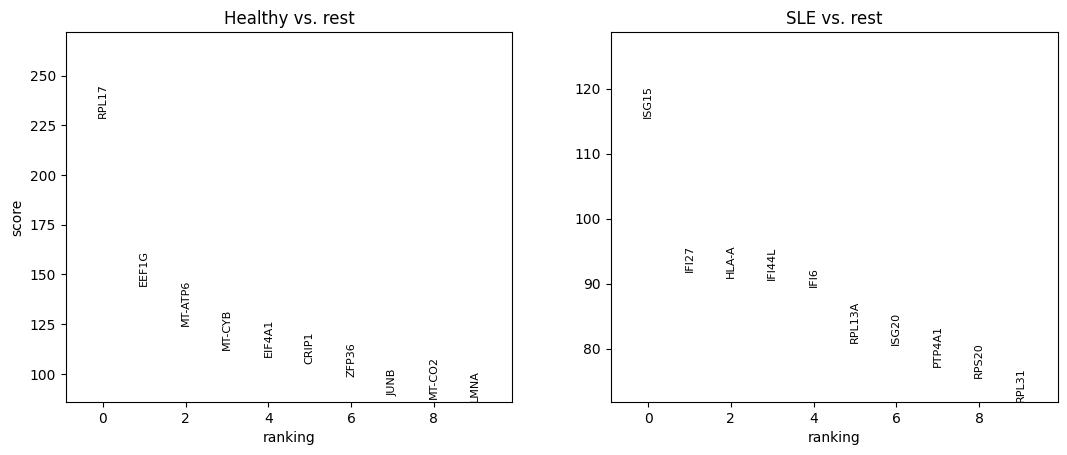

In [75]:
print(adata_t.obs['group'].value_counts())
sc.tl.rank_genes_groups(adata_t, groupby='group', method='t-test')
sc.pl.rank_genes_groups(adata_t, n_genes=10, sharey=False)

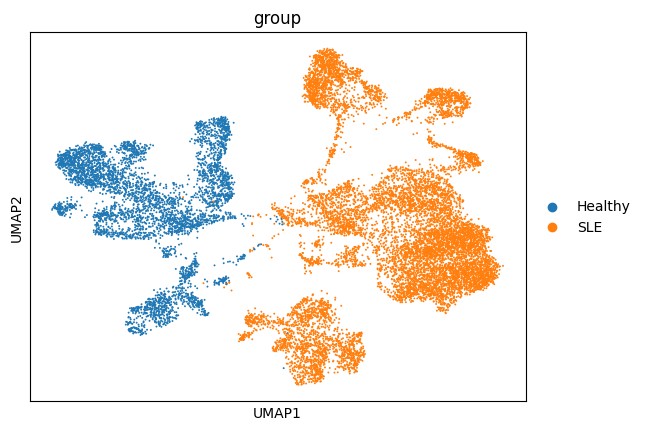

In [76]:
sc.pl.umap(adata_t, color= 'group', cmap='turbo')

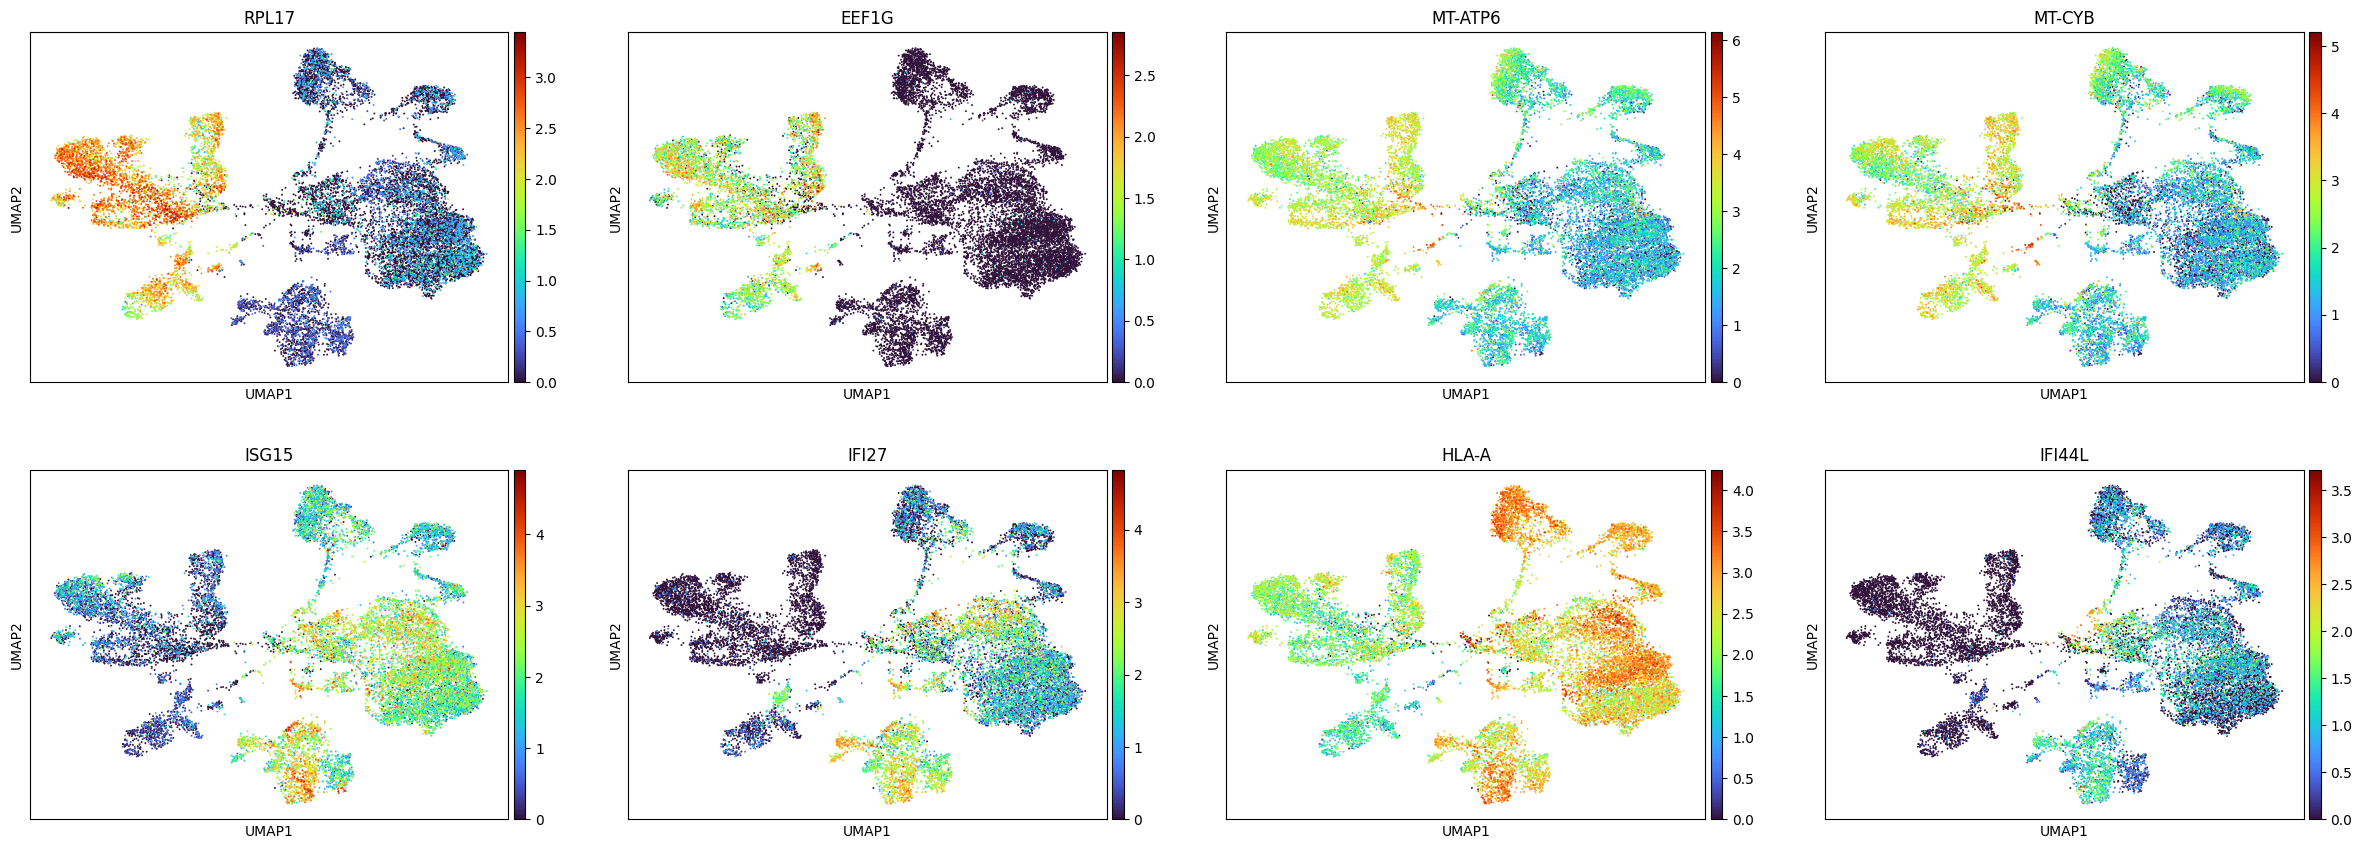

In [77]:
sc.pl.umap(adata_t, color= ['RPL17', 'EEF1G', 'MT-ATP6', 'MT-CYB','ISG15', 'IFI27', 'HLA-A', 'IFI44L'], cmap='turbo')

In [118]:
adata_b = adata_combined[(adata_combined[:,'MS4A1'].X > 0)]

In [119]:
adata_b

View of AnnData object with n_obs × n_vars = 1860 × 31915
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'

In [120]:
sc.pp.normalize_total(adata_b, inplace=True)

normalizing counts per cell


/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [121]:
sc.pp.log1p(adata_b)

In [122]:
mean_expr_b = pd.Series(adata_b.X.mean(axis=0).A1 if hasattr(adata_b.X.mean(axis=0), 'A1') else adata_b.X.mean(axis=0).ravel())
mean_expr_b.index = adata_b.var.index
mean_expr_b.describe()

count    31915.000000
mean         0.039783
std          0.159653
min          0.000000
25%          0.000000
50%          0.000999
75%          0.022244
max          5.403923
dtype: float64

In [125]:
# Ensure CD19 is always included, even if its mean expression is below the threshold
genes_to_include = mean_expr[mean_expr_b >= 0.000999].index.tolist()
genes_to_include.append('CD19')
genes_to_include.append('IGHM')
genes_to_include.append('CD1D')
genes_to_include.append('SPN')
genes_to_include.append('CR2')
genes_to_include.append('FCER2')
genes_to_include.append('IGHD')


# Remove duplicates in case 'CD19' is already included
genes_to_include = list(set(genes_to_include))

# Subset the AnnData object
adata_b = adata_b[:, genes_to_include]


In [126]:
adata_b

View of AnnData object with n_obs × n_vars = 1860 × 15959
    obs: 'sample', 'group'
    var: 'gene_ids-0', 'feature_types'
    uns: 'log1p'

In [127]:
sc.tl.pca(adata_b)

computing PCA
    with n_comps=50
    finished (0:00:04)


/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [128]:
sc.pp.neighbors(adata_b, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [129]:
sc.settings.verbosity = 3
sc.tl.umap(adata_b, random_state=0,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


In [130]:
sc.tl.leiden(adata_b)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [131]:
sc.pl.umap(adata_b, color= 'leiden', cmap='turbo', title = 'B Cells')

In [132]:
for group in ['Healthy', "SLE"]:
    adata_group = adata_b[adata_b.obs['group'] == group]
    
    # Plot UMAP for each group
    # sc.pl.umap(adata_group, color=['celltype'], title=f'UMAP - {group} Group', cmap='turbo')
    sc.pl.umap(
    adata_group,
    color= 'MS4A1',
    title=f'MS4A1 - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

In [133]:
count_b = adata_b.obs['group'].value_counts()
count_b

group
SLE        1489
Healthy     371
Name: count, dtype: int64

In [134]:
b_percentage_healthy = count_b[1]/count_all[1]
b_percentage_SLE = count_b[0]/count_all[0]

print("B Cell percentage in healthy group: {}".format(b_percentage_healthy))
print("B Cell percentage in SLE group: {}".format(b_percentage_SLE))

B Cell percentage in healthy group: 0.006170991350632069
B Cell percentage in SLE group: 0.022706477979748688


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94201/3253326991.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_percentage_healthy = count_b[1]/count_all[1]
/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94201/3253326991.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_percentage_SLE = count_b[0]/count_all[0]


In [135]:
sc.tl.rank_genes_groups(adata_b, groupby='group', method='t-test')
sc.pl.rank_genes_groups(adata_b, n_genes=10, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [136]:
sc.pl.umap(adata_b, color= 'group', cmap='turbo')

In [137]:
sc.pl.umap(adata_b, color= ['RPL17', 'MT-ATP6','MT-CYB','EEF1G','HLA-DRA', 'IFI44L', 'IGKC', 'HLA-DQA1',], cmap='turbo')

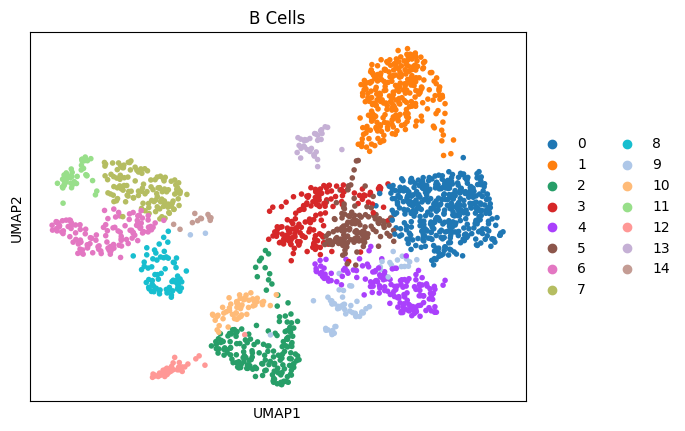

In [138]:
sc.pl.umap(adata_b, color= 'leiden', cmap='turbo', title = 'B Cells')

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


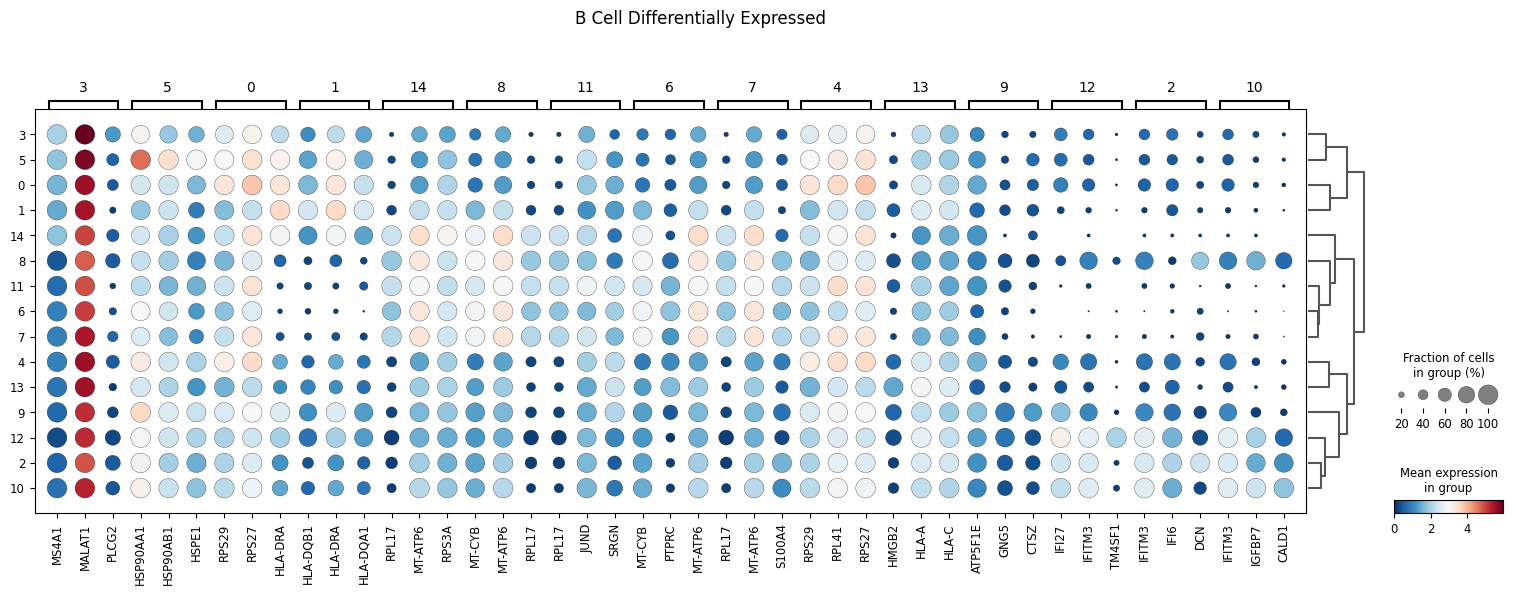

In [174]:
sc.tl.rank_genes_groups(adata_b, "leiden", method="t-test")
sc.pl.rank_genes_groups_dotplot(adata_b, n_genes=3, title='B Cell Differentially Expressed', cmap='RdBu_r')

In [165]:
# Retrieve the results from the 'rank_genes_groups' analysis
ranked_genes = adata_b.uns['rank_genes_groups']

# Print the top 3 genes for each cluster
for cluster in ranked_genes['names'].dtype.names:
    print(f"Top 3 genes for cluster {cluster}:")
    print(ranked_genes['names'][cluster][:3])  # Get top 3 genes for each cluster
    print()


Top 3 genes for cluster 0:
['RPS29' 'RPS27' 'HLA-DRA']

Top 3 genes for cluster 1:
['HLA-DQB1' 'HLA-DRA' 'HLA-DQA1']

Top 3 genes for cluster 2:
['IFITM3' 'IFI6' 'DCN']

Top 3 genes for cluster 3:
['MS4A1' 'MALAT1' 'PLCG2']

Top 3 genes for cluster 4:
['RPS29' 'RPL41' 'RPS27']

Top 3 genes for cluster 5:
['HSP90AA1' 'HSP90AB1' 'HSPE1']

Top 3 genes for cluster 6:
['MT-CYB' 'PTPRC' 'MT-ATP6']

Top 3 genes for cluster 7:
['RPL17' 'MT-ATP6' 'S100A4']

Top 3 genes for cluster 8:
['MT-CYB' 'MT-ATP6' 'RPL17']

Top 3 genes for cluster 9:
['ATP5F1E' 'GNG5' 'CTSZ']

Top 3 genes for cluster 10:
['IFITM3' 'IGFBP7' 'CALD1']

Top 3 genes for cluster 11:
['RPL17' 'JUND' 'SRGN']

Top 3 genes for cluster 12:
['IFI27' 'IFITM3' 'TM4SF1']

Top 3 genes for cluster 13:
['HMGB2' 'HLA-A' 'HLA-C']

Top 3 genes for cluster 14:
['RPL17' 'MT-ATP6' 'RPS3A']



In [166]:
celltype = {'celltype':[],}
celltype['celltype'] = [
    'B.RPS29-RPS27-HLADRA' if str(leiden) == '0' else 
    'B.HLADBQ1-HLADRA-HLADQA1' if str(leiden) == '1' else 
    'B.IFITM3-IFI6-DCN' if str(leiden) == '2' else 
    'B.MALAT1-PLCG2' if str(leiden) == '3' else 
    'B.RPS29-RPL41-RPS27' if str(leiden) == '4' else
    'B.HSP90AA1-HSP90AB1-HSPE1' if str(leiden) == '5' else
    'B.MTCYB-PTPRC-MTATP6' if str(leiden) == '6' else
    'B.RPL17-MTATP6-S100A4' if str(leiden) == '7' else 
    'B.RPL17-MTCYB-MTATP6' if str(leiden) == '8' else
    'B.ATP5F1E-GNG5-CTSZ' if str(leiden) == '9' else
    'B.IFITM3-IGFBP7-CALD1' if str(leiden) == '10' else 
    'B.RPL17-JUND-SRGN' if str(leiden) == '11' else
    'B.IFITM3-IFI27-TM4SF1' if str(leiden) == '12' else
    'B.HMGB2-HLAA-HLAC' if str(leiden) == '13' else
    'B.RPL17-RPS3A-MTATP6' if str(leiden) == '14' else
    None
    for leiden in adata_b.obs['leiden']
]

In [167]:
df_celltypes = pd.DataFrame(celltype)

In [168]:
df_celltypes.index = adata_b.obs.index

In [169]:
adata_b.obs['celltype'] = df_celltypes["celltype"]

In [172]:
import scanpy as sc
import matplotlib.pyplot as plt

# Plot the UMAP
sc.pl.umap(
    adata_b,
    color=['celltype'],
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

# Add cluster labels
ax = plt.gca()  # Get current axis
for cluster in adata_b.obs['leiden'].cat.categories:
    # Find the coordinates of cells in this cluster
    cluster_mask = adata_b.obs['leiden'] == cluster
    cluster_coords = adata_b.obsm['X_umap'][cluster_mask]
    # Calculate cluster centroid
    x, y = cluster_coords[:, 0].mean(), cluster_coords[:, 1].mean()
    # Add text label
    ax.text(x, y, cluster, color='black', fontsize=10, weight='bold', ha='center', va='center')

# Display the plot
plt.show()


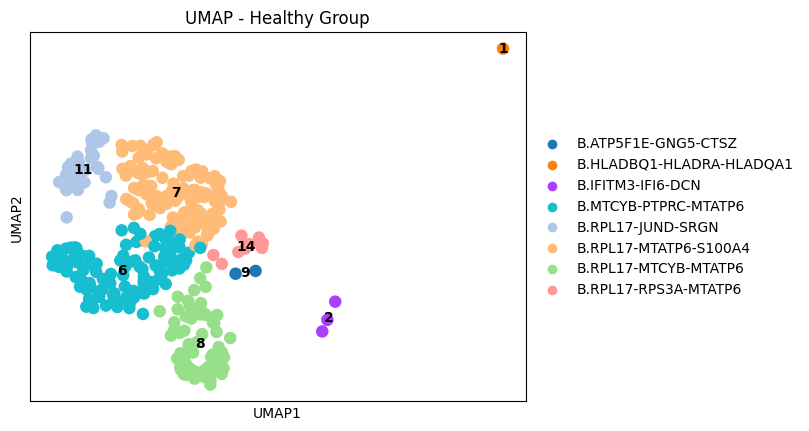

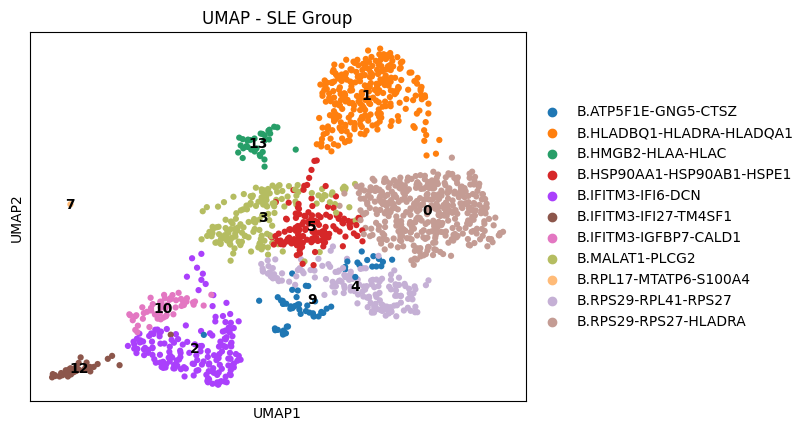

In [173]:
for group in ['Healthy', 'SLE']:
    adata_group = adata_b[adata_b.obs['group'] == group]
    
    # Plot UMAP for each group
    # sc.pl.umap(adata_group, color=['celltype'], title=f'UMAP - {group} Group', cmap='turbo')
    sc.pl.umap(
    adata_group,
    color=['celltype'],
    title=f'UMAP - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

# Add cluster labels
    ax = plt.gca()  # Get current axis
    for cluster in adata_group.obs['leiden'].cat.categories:
        # Find the coordinates of cells in this cluster
        cluster_mask = adata_group.obs['leiden'] == cluster
        cluster_coords = adata_group.obsm['X_umap'][cluster_mask]
        # Calculate cluster centroid
        x, y = cluster_coords[:, 0].mean(), cluster_coords[:, 1].mean()
        # Add text label
        ax.text(x, y, cluster, color='black', fontsize=10, weight='bold', ha='center', va='center')

    # Display the plot
    plt.show()